In [ ]:
!pip install ruptures
!pip install umap-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pickle as pickle
import glob
import pandas as pd
import numpy as np
import math
import re
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from datetime import datetime
from numba import jit
from sklearn.preprocessing import StandardScaler
import ruptures as rpt  # our package

In [ ]:
# Load your file for analysis:
basepath= [
    '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/',
    '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{p65AD}{UAS-TNTE};{GAL4DBD}{+}/',
    '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/1-fly/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/',
    '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/1-fly/dark/{p65AD}{UAS-TNTE};{GAL4DBD}{+}/',
]

fnames_list = []



4


[['/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/01_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-03T15_18_02DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/02_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-04T13_03_13DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/03_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-05T15_02_36DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/04_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04

In [ ]:
def hampel(vals_orig, k=7, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    #Make copy so original not edited
    vals=vals_orig.copy()
    #Hampel Filter
    L= 1.4826
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    vals[outlier_idx]=np.nan
    return vals, outlier_idx

In [ ]:
import numpy as np
import pandas as pd
import os
from skimage.color import hsv2rgb

arena_dia = 9
pixel_res = 1024
window_size = 10
fps = 30

vel_df_list = []
slide_df_list = []

# Iterate over the file names
# for group_id, fnames_group in enumerate(fnames_list):
for group_id, fnames_group in enumerate(fnames_list):
    for exp_id, c in enumerate(fnames_group):
        print('File:', c)
        # Load the dataframe from a file
        df = pd.read_csv(c, header=[0, 1, 2], skiprows=[0], index_col=0)

        # Remove all columns containing "likelihood"
        df = df.loc[:, ~df.columns.get_level_values(2).str.contains('likelihood')]

        # Remove WingL and WingR at level 1 of column
        df = df.loc[:, ~df.columns.get_level_values(1).str.contains('Wing')]

        # Flatten the multi-level column index
        df.columns = df.columns.map('_'.join)
        # print('df has nan values:', df.isnull().values.sum())

        df = df * arena_dia / pixel_res

        # Downsample the data to 30Hz
        df = df.iloc[::2].reset_index(drop=True)


        def get_velocities_windows(df):
            data = df.values

            num_flies = data.shape[1] // 4
            num_rows = data.shape[0]

            vel_stacks = []
            sliding_windows = []

            for fly_id in range(num_flies):  # Added fly_id loop
                g_id = np.full(num_rows, group_id)
                e_id = np.full(num_rows, exp_id)
                f_id = np.full(num_rows, fly_id)

                # Get coordinates of one fly
                each_fly = data[:, fly_id * 4:(fly_id + 1) * 4]

                # Extracting hx, hy, tx, ty columns from the array
                hx = each_fly[:, 0]
                hy = each_fly[:, 1]
                tx = each_fly[:, 2]
                ty = each_fly[:, 3]

                # coords.append(each_fly[:, :4])

                # Calculating cx and cy
                cx = hx - tx / 2
                cy = hy - ty / 2

                # Calculate the heading (Body axis) vector
                x = hx - tx
                y = hy - ty

                # Calculate the angle between the vector and the y-axis
                angle_rad = np.arctan2(x, y)  # Swap x and y
                angle = np.degrees(angle_rad)

                # Calculate theta using the shifted values
                # delta_angle = angle.shift(-1) - angle
                delta_angle = np.diff(angle)

                # Adjust delta_angle based on the logic using a lambda function
                adjust_angle = lambda angle: angle - 360 if angle > 180 else (angle + 360 if angle < -180 else angle)

                theta = np.vectorize(adjust_angle)(delta_angle)
                theta = np.insert(theta, 0, np.nan)

                t = (np.arange(num_rows) / fps)
                time_interval = np.diff(t, prepend=np.nan)

                distance = np.sqrt((np.diff(cx, prepend=np.nan))**2 + (np.diff(cy, prepend=np.nan))**2)

                # Calculate forward-backward velocity
                forward_backward_vel  = distance * np.cos(np.radians(theta))
                vt_cm = forward_backward_vel / time_interval

                # Calculate ipsi-contralateral velocity
                ipsi_contralateral_vel  = distance * np.sin(np.radians(theta))
                vs_cm = ipsi_contralateral_vel / time_interval

                # Calculate angular velocity
                vr_cm = theta / time_interval

                vel = np.column_stack([vt_cm, vs_cm, vr_cm])

                scaler = StandardScaler()
                scaler.fit(vel)
                vel_scaled = scaler.transform(vel)
                vel_result = np.column_stack([t, time_interval, g_id, e_id, f_id, each_fly[:, :4], vel])
                vel_stacks.append(vel_result)

            return np.row_stack(vel_stacks)

        out_velocities = get_velocities_windows(df)

        vel_col_name = ['time', 'time_interval', 'group_id', 'exp_id', 'fly_id', 'Hx', 'Hy', 'Tx', 'Ty', 'vt_cm', 'vs_cm', 'vr_cm']
        # slide_col_name = [f'feature_{i}' for i in range(window_size * 3)] + ['win_idx', 'fly_id', 'exp_id', 'group_id']

        vel_df = pd.DataFrame(out_velocities, columns=vel_col_name)
        # slide_win_df = pd.DataFrame(out_slide_windows, columns=slide_col_name)

        vel_df_list.append(vel_df)
        # slide_df_list.append(slide_win_df)

# Concatenate all the separate DataFrames into a single DataFrame
vel_df_result = pd.concat(vel_df_list, ignore_index=True)
scaled_data = StandardScaler().fit_transform(vel_df_result[['vt_cm', 'vs_cm', 'vr_cm']])
vel_df_result[['vt_scaled', 'vs_scaled', 'vr_scaled']] = scaled_data

# slide_df_result = pd.concat(slide_df_list, ignore_index=True)
print(vel_df_result.head())

# print(slide_df_result.head())

File: /content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/01_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-03T15_18_02DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv
File: /content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/02_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-04T13_03_13DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv
File: /content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/03_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-05T15_02_36DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv
File: /content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/04_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2

In [ ]:
import numpy as np

window_size = 10
step_size = 1

# Group by unique identifiers
grouped_data = vel_df_result.groupby(['group_id', 'exp_id', 'fly_id'])

# Initialize an empty list to store sliding windows
sliding_windows_list = []

# Loop through each group
for (group_id, exp_id, fly_id), data in grouped_data:
    vel = data.iloc[:, -3:].values
    num_rows = vel.shape[0]

    # Calculate indices for sliding windows without using a loop
    window_indices = np.arange(1, num_rows - window_size, step_size)
    window_starts = window_indices[:, np.newaxis]
    window_indices = window_starts + np.arange(window_size)

    # Extract sliding windows using advanced indexing
    vels = vel[window_indices]

    # Calculate ss_win and sr_win without using loops
    vs_win = vels[:, :, 1]
    vr_win = vels[:, :, 2]
    ss_win = np.abs(vs_win - vs_win[:, 0][:, np.newaxis])
    sr_win = np.abs(vr_win - vr_win[:, 0][:, np.newaxis])

    # Stack all features for each sliding window
    vt_win = vels[:, :, 0]
    vel_window = np.column_stack([vt_win, ss_win, sr_win]).reshape(len(window_indices), -1)

    # Append metadata and sliding windows to the list
    metadata = np.column_stack([window_starts, np.full(len(window_indices), fly_id), np.full(len(window_indices), exp_id), np.full(len(window_indices), group_id)])
    vel_window = np.column_stack([vel_window, metadata])
    sliding_windows_list.append(vel_window)

# Concatenate the sliding windows and create a DataFrame
out_sliding_windows = pd.DataFrame(np.vstack(sliding_windows_list))
out_sliding_windows.columns = [f'feature_{i}' for i in range(window_size * 3)] + ['win_idx', 'fly_id', 'exp_id', 'group_id']


In [ ]:
out_sliding_windows.group_id.unique()

array([0., 1., 2., 3.])

In [ ]:
import umap

In [ ]:
df_sampled = out_sliding_windows.sample(n = 100000, random_state=42, axis=0)
dt = df_sampled.iloc[:, :-4]

In [ ]:
color = df_sampled.iloc[:, -1]
color

2414268    0.0
5730461    2.0
5848920    2.0
235093     0.0
2693819    0.0
          ... 
4076126    1.0
4298487    1.0
341879     0.0
5354869    1.0
2657308    0.0
Name: group_id, Length: 100000, dtype: float64

In [ ]:
embedding = umap.UMAP(n_neighbors=30,
                      min_dist=0.99,
                      metric='manhattan').fit_transform(dt)

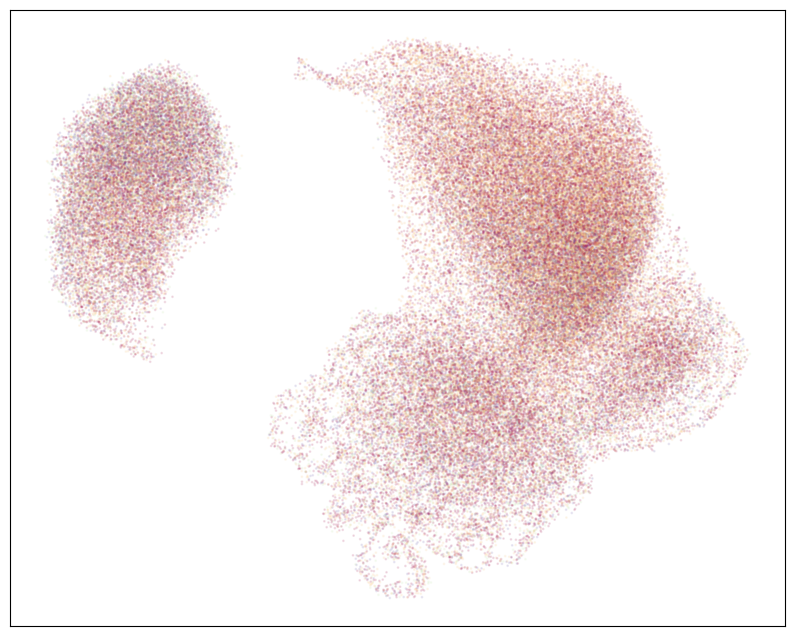

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding.T, s=1,
            c=color,
            cmap='Spectral',
            alpha=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

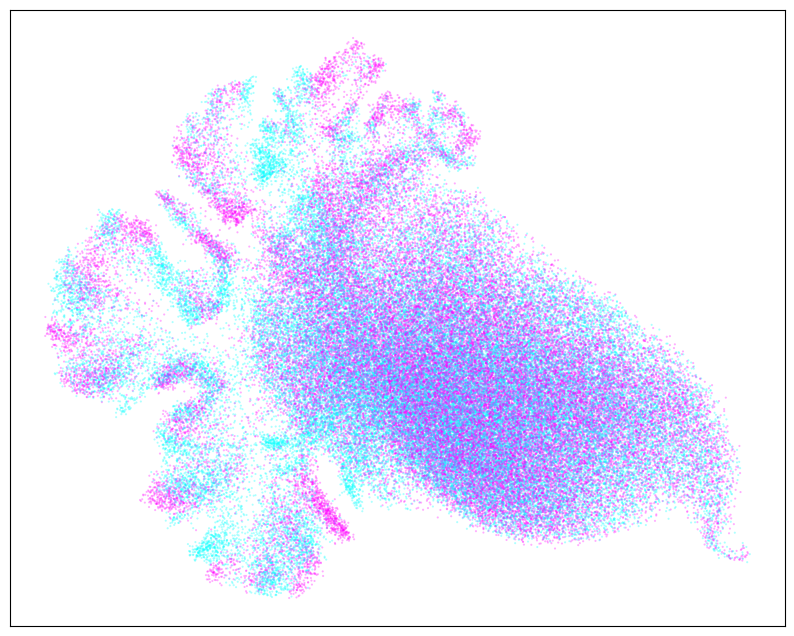

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding.T, s=0.3,
            c=color,
            cmap='cool',
            alpha=0.3)
plt.setp(ax, xticks=[], yticks=[])
plt.show()
# cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(classes)
# plt.title('Fashion MNIST Embedded via UMAP');

In [ ]:
# Define the filenames for saving the DataFrames
final_df_filename = "/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/R20G06VT055404TNT_p65GAL4TNT_male_xy_smooth_20230601.pickle"

# Check if the final_df file already exists
if os.path.isfile(final_df_filename):
    # Load the final_df DataFrame from the saved file
    final_df = pd.read_pickle(final_df_filename)
    print(f"Loaded 'final_df' DataFrame from '{final_df_filename}'.")

else:
    arena_dia = 9
    fps = 60
    pix_res = 1024

    cm_per_pixel = arena_dia / pix_res

    df_stack = []

    for j in range(len(fnames_list)):
        strains = ['R20G06VT055404TNT', 'p65GAL4TNT']
        for i, c in enumerate(fnames_list[j]):
            print(c)
            # Load the dataframe from a file
            df = pd.read_csv(c, header=[0, 1, 2], skiprows=[0], index_col=0)

            # Remove all columns containing "likelihood"
            df = df.loc[:, ~df.columns.get_level_values(2).str.contains('likelihood')]

            # Remove WingL and WingR at level 1 of column
            df = df.loc[:, ~df.columns.get_level_values(1).str.contains('Wing')]

            # Flatten the multi-level column index
            df.columns = df.columns.map('_'.join)
            print('df has nan values: ' + str(df.isnull().values.sum()))

            df['t'] = 1000000.0 * (df.index / fps)

            # Create the new DataFrame
            new_df = pd.DataFrame()
            values = list(range(1, 11))  # List of values 1 to 10
            num_values = len(df) * len(values)
            fly_id = list(itertools.chain.from_iterable(itertools.repeat(x, num_values // len(values)) for x in values))
            frame = list(itertools.islice(itertools.cycle(df.index), num_values))

            new_df['fly_id'] = fly_id
            new_df['exp_id'] = i+1
            new_df['strain'] = strains[j]
            new_df['name'] = strains[j] + '_' + str(i+1) + '_' + str(fly_id[0])
            new_df['t'] = (np.array(frame) / fps)

            new_df['Hx'] = df.filter(like='Head_x').values.flatten('F') * cm_per_pixel
            new_df['Hy'] = df.filter(like='Head_y').values.flatten('F') * cm_per_pixel
            new_df['Tx'] = df.filter(like='Tail_x').values.flatten('F') * cm_per_pixel
            new_df['Ty'] = df.filter(like='Tail_y').values.flatten('F') * cm_per_pixel

            # Calculate centroid of flies
            new_df['Cx'] = (new_df['Hx'] + new_df['Tx']) / 2
            new_df['Cy'] = (new_df['Hy'] + new_df['Ty']) / 2

            # Calculate the heading (Body axis) vector
            new_df['x'] = new_df['Hx'] - new_df['Tx']
            new_df['y'] = new_df['Hy'] - new_df['Ty']

            # Calculate the angle between the vector and the y-axis
            new_df['angle_rad'] = np.arctan2(new_df['x'], new_df['y'])  # Swap x and y
            new_df['angle'] = np.degrees(new_df['angle_rad'])

            # Downsample the data to 30Hz
            new_df = new_df.iloc[::2].reset_index(drop=True)

            # Calculate theta using the shifted values
            delta_angle = new_df['angle'].shift(-1) - new_df['angle']

            # Adjust delta_angle based on the logic using a lambda function
            adjust_angle = lambda angle: angle - 360 if angle > 180 else (angle + 360 if angle < -180 else angle)
            delta_angle = delta_angle.apply(adjust_angle)

            new_df['theta'] = delta_angle

            time_interval = new_df['t'].diff()

            distance = np.sqrt((new_df['Cx'].diff())**2 + (new_df['Cy'].diff())**2)

            # Calculate forward-backward velocity
            forward_backward_vel  = distance * np.cos(np.radians(new_df['theta']))
            new_df['vt_cm'] = forward_backward_vel / time_interval

            # Calculate ipsi-contralateral velocity
            ipsi_contralateral_vel  = distance * np.sin(np.radians(new_df['theta']))
            new_df['vs_cm'] = ipsi_contralateral_vel / time_interval

            # Calculate angular velocity
            new_df['vr_cm'] = new_df['theta'] / time_interval

            # Define smoothing sigma
            sigma = 1

            # Apply Gaussian smoothing to 'vt', 'vs', and 'vr'
            new_df['vt_cm_smooth'] = gaussian_filter1d(new_df['vt_cm'], sigma=sigma)
            new_df['vs_cm_smooth'] = gaussian_filter1d(new_df['vs_cm'], sigma=sigma)
            new_df['vr_cm_smooth'] = gaussian_filter1d(new_df['vr_cm'], sigma=sigma)

            df_stack.append(new_df)

    final_df = pd.concat(df_stack)
    final_df.reset_index().rename(columns={df.index.name:'frame'})
    print("DataFrame 'final_df' has been created.")

    # Save the final_df DataFrame to the file
    final_df.to_pickle(final_df_filename)
    print(f"The DataFrame has been saved to '{final_df_filename}'.")
final_df.head()

Loaded 'final_df' DataFrame from '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/R20G06VT055404TNT_p65GAL4TNT_male_xy_smooth_20230601.pickle'.


,fly_id,exp_id,strain,name,t,Hx,Hy,Tx,Ty,Cx,...,y,angle_rad,angle,theta,vt_cm,vs_cm,vr_cm,vt_cm_smooth,vs_cm_smooth,vr_cm_smooth
0,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.000000,6.846214,3.330861,6.952931,3.488036,6.899572,...,-0.157175,-2.545121,-145.824717,-0.261085,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.033333,6.845977,3.331151,6.951674,3.488361,6.898825,...,-0.157210,-2.549678,-146.085802,-0.092135,0.024238,-0.000039,-2.764037,NaN,NaN,NaN
2,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.066667,6.846302,3.330932,6.951727,3.488282,6.899014,...,-0.157351,-2.551286,-146.177937,-0.019059,0.007227,-0.000002,-0.571774,NaN,NaN,NaN
3,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.100000,6.846398,3.331046,6.951665,3.488273,6.899032,...,-0.157228,-2.551619,-146.196996,-4.372119,0.001663,-0.000127,-131.163580,NaN,NaN,NaN
4,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.133333,6.863089,3.330958,6.951744,3.488098,6.907417,...,-0.157140,-2.627927,-150.569115,-0.098512,0.251574,-0.000433,-2.955369,NaN,NaN,NaN


In [ ]:
final_df.shape

(5399300, 22)

In [ ]:
data = final_df.copy()
data.head()

,fly_id,exp_id,strain,name,t,Hx,Hy,Tx,Ty,Cx,...,y,angle_rad,angle,theta,vt_cm,vs_cm,vr_cm,vt_cm_smooth,vs_cm_smooth,vr_cm_smooth
0,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.000000,6.846214,3.330861,6.952931,3.488036,6.899572,...,-0.157175,-2.545121,-145.824717,-0.261085,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.033333,6.845977,3.331151,6.951674,3.488361,6.898825,...,-0.157210,-2.549678,-146.085802,-0.092135,0.024238,-0.000039,-2.764037,NaN,NaN,NaN
2,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.066667,6.846302,3.330932,6.951727,3.488282,6.899014,...,-0.157351,-2.551286,-146.177937,-0.019059,0.007227,-0.000002,-0.571774,NaN,NaN,NaN
3,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.100000,6.846398,3.331046,6.951665,3.488273,6.899032,...,-0.157228,-2.551619,-146.196996,-4.372119,0.001663,-0.000127,-131.163580,NaN,NaN,NaN
4,1,1,R20G06VT055404TNT,R20G06VT055404TNT_1_1,0.133333,6.863089,3.330958,6.951744,3.488098,6.907417,...,-0.157140,-2.627927,-150.569115,-0.098512,0.251574,-0.000433,-2.955369,NaN,NaN,NaN


In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.utils import resample


base_dir = "/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/"
output_folder = "output_windows"

# Create the output folder if it doesn't exist
output_path = os.path.join(base_dir, output_folder)
os.makedirs(output_path, exist_ok=True)

def generate_egocentric_pose(raw_data):
    data = raw_data.copy()
    hx_first_row = data[0, 0]
    hy_first_row = data[0, 1]
    tx_first_row = data[0, 2]
    ty_first_row = data[0, 3]

    translation = [-hx_first_row, -hy_first_row]
    rotation = np.arctan2(tx_first_row - hx_first_row, -(ty_first_row - hy_first_row))

    hx_affine = (data[:, 0] + translation[0]) * np.cos(rotation) + (data[:, 1] + translation[1]) * np.sin(rotation)
    hy_affine = -(data[:, 0] + translation[0]) * np.sin(rotation) + (data[:, 1] + translation[1]) * np.cos(rotation)
    tx_affine = (data[:, 2] + translation[0]) * np.cos(rotation) + (data[:, 3] + translation[1]) * np.sin(rotation)
    ty_affine = -(data[:, 2] + translation[0]) * np.sin(rotation) + (data[:, 3] + translation[1]) * np.cos(rotation)

    return np.column_stack((hx_affine, hy_affine, tx_affine, ty_affine))


def generate_sliding_windows(data, window_size, stride=None, columns=None, norm_factor=None, num_bootstrap=None, random_state=None):
    samples = []
    n = data.shape[0]

    if num_bootstrap is None:
        # Slide through all time windows
        for start_index in range(0, n - (window_size - 1), stride):
            end_index = start_index + window_size
            sample = data[start_index:end_index]

            if columns:
                sample = sample[:, columns]

            sample = generate_egocentric_pose(sample)

            sliding_window_sample = sample.flatten('F') / norm_factor
            sliding_window_sample = list(sliding_window_sample) + [slice(start_index, start_index + window_size)]
            samples.append(sliding_window_sample)
    else:
        # Perform bootstrap sampling
        rng = np.random.default_rng(random_state)
        bootstrap_indices = rng.choice(n - (window_size - 1), num_bootstrap, replace=False)

        for index in bootstrap_indices:
            start_index = index
            end_index = start_index + window_size
            sample = data[start_index:end_index]

            if columns:
                sample = sample[:, columns]

            sample = generate_egocentric_pose(sample)

            sliding_window_sample = sample.flatten('F') / norm_factor
            sliding_window_sample = list(sliding_window_sample) + [slice(start_index, start_index + window_size)]
            samples.append(sliding_window_sample)

    sliding_window_data = pd.DataFrame(samples)
    sliding_window_data.rename(columns={sliding_window_data.columns[-1]: 'slice_range'}, inplace=True)
    return sliding_window_data


def get_timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def generate_save_windows(data, window_size, stride=1, pose=True, columns=None,
                          strain=None, norm_factor=9, num_bootstrap=50, random_state=42,
                          verbose=False, output_path=None):
    num_experiments = len(np.unique(data[:, 4]))
    num_flies = len(np.unique(data[:, 5]))
    window_samples = []

    for strain in np.unique(data[:, 6]):
        if verbose:
            print(f"Processing strain: {strain}")

        strain_data = data[(data[:, 6] == strain)]

        for i, exp_id in enumerate(np.unique(strain_data[:, 4])):
            exp_id = int(exp_id)

            if verbose:
                print(f"\tProcessing experiment {i+1}/{num_experiments} (exp_id: {exp_id})")

            exp_data = strain_data[(strain_data[:, 4] == exp_id)]

            for j, fly_id in enumerate(np.unique(exp_data[:, 5])):
                fly_id = int(fly_id)

                if verbose:
                    print(f"\t\tProcessing fly {j+1}/{num_flies} (fly_id: {fly_id})")

                fly_data = exp_data[(exp_data[:, 5] == fly_id)]

                sliding_window_data = generate_sliding_windows(
                    fly_data[:, :4], window_size, stride=stride, columns=columns, norm_factor=norm_factor, num_bootstrap=num_bootstrap,
                )

                sliding_window_data['exp_id'] = exp_id
                sliding_window_data['fly_id'] = fly_id
                sliding_window_data['strain'] = strain
                window_samples.append(sliding_window_data)

    all_samples = pd.concat(window_samples)

    timestamp = get_timestamp()

    if output_path:
        if num_bootstrap is None:
            output_filename = f"win_{window_size}_fly_all_exp_all_strain_all_{timestamp}.pkl"
            output_filepath = os.path.join(output_path, output_filename)
            if verbose:
                print(f"Saved all sliding window samples for all experiments, flies, and strains to {output_filepath}")

        else:
            output_filename = f"bootstrap_{num_bootstrap}_win_{window_size}_fly_{fly_id}_exp_{exp_id}_strain_{strain}_{timestamp}.pkl"
            output_filepath = os.path.join(output_path, output_filename)

            if verbose:
                print(f"Saved bootstrap samples for fly {fly_id}, experiment {exp_id}, bootstrap {num_bootstrap} (strain {strain}) to {output_filepath}")


        all_samples.to_pickle(output_filepath)

    return all_samples





# # Define the filenames for saving the DataFrames
# all_samples_filepath = "/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/output_windows/win_4_fly_10_exp_10_strain_all_20230602_214507.pkl"

# # Check if the final_df file already exists
# if os.path.isfile(all_samples_filepath):
#     # Load the final_df DataFrame from the saved file
#     all_samples = pd.read_pickle(all_samples_filepath)
#     print(f"Loaded 'all_samples' DataFrame from '{all_samples_filepath}'.")
# else:
#     # Example usage
#     window_size = 4
#     stride = 1
#     pose = True
#     columns = [0, 1, 2, 3]  # Replace with the desired column indices
#     norm_factor = 9
#     verbose = True

#     data_array = data[['Hx', 'Hy', 'Tx', 'Ty', 'exp_id', 'fly_id', 'strain']].to_numpy()
#     all_samples = generate_save_windows(data_array, window_size, stride=stride, pose=pose, columns=columns, norm_factor=norm_factor, verbose=verbose)

In [ ]:
# Example usage
# window_size = 4
# window_sizes = np.arange(33, 5)
window_sizes = [64]
stride = 1
pose = True
columns = [0, 1, 2, 3]  # Replace with the desired column indices
norm_factor = 9
num_bootstrap = 5
random_state = 42
verbose = True
print(window_sizes)
data_array = data[['Hx', 'Hy', 'Tx', 'Ty', 'exp_id', 'fly_id', 'strain']].to_numpy()
for window_size in window_sizes:
    print(window_size)
    generate_save_windows(data_array, window_size, stride=stride, pose=pose, columns=columns,
                        norm_factor=norm_factor, num_bootstrap=num_bootstrap, random_state=random_state,
                        verbose=verbose, output_path=output_path)

[64]
64
Processing strain: R20G06VT055404TNT
	Processing experiment 1/10 (exp_id: 1)
		Processing fly 1/10 (fly_id: 1)
		Processing fly 2/10 (fly_id: 2)
		Processing fly 3/10 (fly_id: 3)
		Processing fly 4/10 (fly_id: 4)
		Processing fly 5/10 (fly_id: 5)
		Processing fly 6/10 (fly_id: 6)
		Processing fly 7/10 (fly_id: 7)
		Processing fly 8/10 (fly_id: 8)
		Processing fly 9/10 (fly_id: 9)
		Processing fly 10/10 (fly_id: 10)
	Processing experiment 2/10 (exp_id: 2)
		Processing fly 1/10 (fly_id: 1)
		Processing fly 2/10 (fly_id: 2)
		Processing fly 3/10 (fly_id: 3)
		Processing fly 4/10 (fly_id: 4)
		Processing fly 5/10 (fly_id: 5)
		Processing fly 6/10 (fly_id: 6)
		Processing fly 7/10 (fly_id: 7)
		Processing fly 8/10 (fly_id: 8)
		Processing fly 9/10 (fly_id: 9)
		Processing fly 10/10 (fly_id: 10)
	Processing experiment 3/10 (exp_id: 3)
		Processing fly 1/10 (fly_id: 1)
		Processing fly 2/10 (fly_id: 2)
		Processing fly 3/10 (fly_id: 3)
		Processing fly 4/10 (fly_id: 4)
		Processing fl

In [ ]:
import os
import pandas as pd

base_dir = "/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/"
output_folder = "output_windows/5/"
csv_folder = "output_csv/5/"

# Create the output CSV folder if it doesn't exist
os.makedirs(csv_folder, exist_ok=True)

# Get a list of all pickle files in the output folder
pickle_files = [file for file in os.listdir(os.path.join(base_dir, output_folder)) if file.endswith(".pkl")]

# Iterate over each pickle file
for pickle_file in pickle_files:
    pickle_path = os.path.join(base_dir, output_folder, pickle_file)
    csv_file = os.path.splitext(pickle_file)[0] + ".csv"
    csv_path = os.path.join(base_dir, csv_folder, csv_file)

    try:
        # Read the pickle file into a DataFrame
        data = pd.read_pickle(pickle_path)

        # Save the DataFrame as CSV
        data.to_csv(csv_path, index=False)

        print(f"Converted {pickle_file} to {csv_file}")
    except Exception as e:
        print(f"Error converting {pickle_file}: {str(e)}")


Converted bootstrap_5_win_256_fly_10_exp_10_strain_p65GAL4TNT_20230617_155305.pkl to bootstrap_5_win_256_fly_10_exp_10_strain_p65GAL4TNT_20230617_155305.csv
Converted bootstrap_5_win_64_fly_10_exp_10_strain_p65GAL4TNT_20230617_193355.pkl to bootstrap_5_win_64_fly_10_exp_10_strain_p65GAL4TNT_20230617_193355.csv


In [ ]:
ewindow_sizes = np.arange(7, 32, 1)
stride = 1
pose = True
# columns = [0, 1, 2, 3]  # Replace with the desired column indices
norm_factor = 9
verbose = True

data_array = data[['Hx', 'Hy', 'Tx', 'Ty', 'exp_id', 'fly_id', 'strain']].to_numpy()
for window_size in window_sizes:
    print(window_size)
    all_samples = generate_save_windows(data_array, window_size, stride=stride, pose=pose, norm_factor=norm_factor, verbose=verbose)

7
Processing strain: R20G06VT055404TNT
	Processing experiment 1/10 (exp_id: 1)
		Processing fly 1/10 (fly_id: 1)
		Processing fly 2/10 (fly_id: 2)
		Processing fly 3/10 (fly_id: 3)
		Processing fly 4/10 (fly_id: 4)
		Processing fly 5/10 (fly_id: 5)
		Processing fly 6/10 (fly_id: 6)
		Processing fly 7/10 (fly_id: 7)
		Processing fly 8/10 (fly_id: 8)
		Processing fly 9/10 (fly_id: 9)
		Processing fly 10/10 (fly_id: 10)
	Processing experiment 2/10 (exp_id: 2)
		Processing fly 1/10 (fly_id: 1)
		Processing fly 2/10 (fly_id: 2)
		Processing fly 3/10 (fly_id: 3)
		Processing fly 4/10 (fly_id: 4)
		Processing fly 5/10 (fly_id: 5)
		Processing fly 6/10 (fly_id: 6)
		Processing fly 7/10 (fly_id: 7)
		Processing fly 8/10 (fly_id: 8)
		Processing fly 9/10 (fly_id: 9)
		Processing fly 10/10 (fly_id: 10)
	Processing experiment 3/10 (exp_id: 3)
		Processing fly 1/10 (fly_id: 1)
		Processing fly 2/10 (fly_id: 2)
		Processing fly 3/10 (fly_id: 3)
		Processing fly 4/10 (fly_id: 4)
		Processing fly 5/10

KeyboardInterrupt: ignored

In [ ]:
vel = final_df.copy()
#Get species-wise vr
vr = vel.groupby('strain')['vr_cm_smooth'].apply(list).to_dict()

#Calculate species-wise acf
acfs = {}
for strain, vr_list in vr.items():
    acfs[strain] = np.correlate(np.array(vr_list).flatten(), np.array(vr_list).flatten(), mode='full')[len(vr_list)-1:]

#Plot
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(20, 10))
for i, (strain, acf) in enumerate(acfs.items()):
    ax = axes[i//8, i%8]
    ax.plot(acf, color='gray70', linewidth=3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax.axvline(x=np.argmax(acf>0), color='red', linestyle='--', linewidth=1.5)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time')
    ax.set_ylabel('Correlation')
    ax.set_title('{} = {}'.format(strain, np.argmax(acf>0)), fontsize=15, fontweight='bold')
fig.tight_layout()

<Axes: >

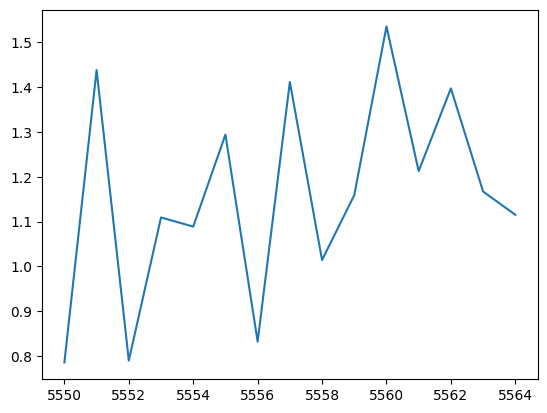

In [ ]:
# Define the desired 'fly_id' and 'exp_id'
# target_fly = final_df.name.unique()[10]
target_fly = 'p65GAL4TNT_1_1'
colors = []
start = 5550
end = start+15
# Filter the final dataframe based on desired 'fly_id' and 'exp_id'
filtered_df = final_df[(final_df.name == target_fly)].reset_index(drop=True).iloc[start:end]

filtered_df.vt.plot()
# filtered_df.Vy.plot()
# filtered_df.Ty.plot()

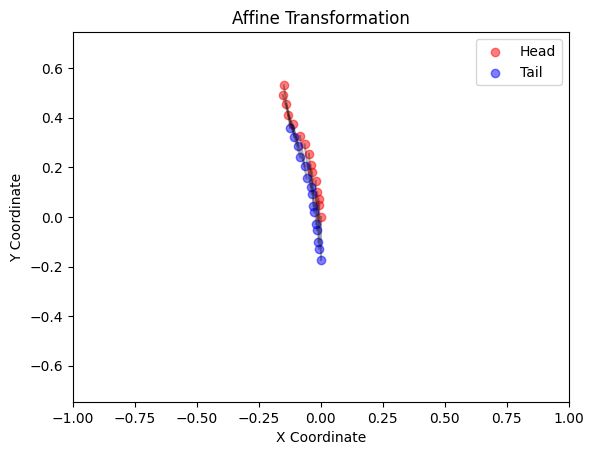

In [ ]:
# Get the coordinates of the first row
hx_first_row = filtered_df['Hx'].iloc[0]
hy_first_row = filtered_df['Hy'].iloc[0]
tx_first_row = filtered_df['Tx'].iloc[0]
ty_first_row = filtered_df['Ty'].iloc[0]

# Calculate the translation and rotation values for the affine transformation
translation = np.array([-hx_first_row, -hy_first_row])
rotation = np.arctan2(tx_first_row - hx_first_row, -(ty_first_row - hy_first_row))

# Apply the affine transformation to the coordinates
hx_affine = (filtered_df['Hx']  + translation[0]) * np.cos(rotation) + (filtered_df['Hy']  + translation[1]) * np.sin(rotation)
hy_affine = -(filtered_df['Hx']  + translation[0]) * np.sin(rotation) + (filtered_df['Hy']  + translation[1]) * np.cos(rotation)
tx_affine = (filtered_df['Tx']  + translation[0]) * np.cos(rotation) + (filtered_df['Ty']  + translation[1]) * np.sin(rotation)
ty_affine = -(filtered_df['Tx']  + translation[0]) * np.sin(rotation) + (filtered_df['Ty']  + translation[1]) * np.cos(rotation)

# Connect the first row of Head and Tail coordinates with a black line
plt.plot([hx_affine, tx_affine], [hy_affine, ty_affine], color='black', alpha=0.3)

# Plot the transformed coordinates
plt.scatter(hx_affine, hy_affine, color='red', label='Head', alpha=0.5)
plt.scatter(tx_affine, ty_affine, color='blue', label='Tail', alpha=0.5)

# Set the axis labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Affine Transformation')

# Set the aspect ratio to be the same
plt.axis('equal')

# Set the x-axis and y-axis limits
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Add a legend
plt.legend()

# Show the plot
plt.show()

<Axes: >

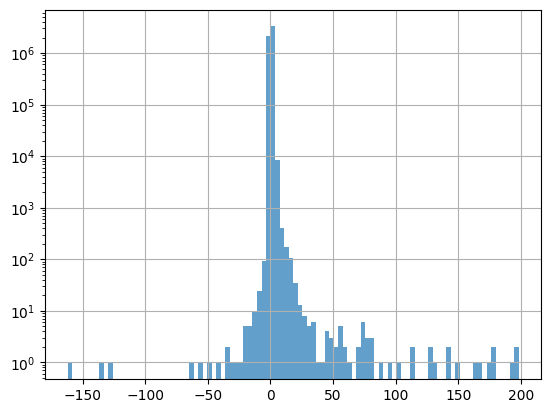

In [ ]:
final_df.vt_smooth.hist(bins=100,
                 log=True,
                 alpha=0.7,
                    )


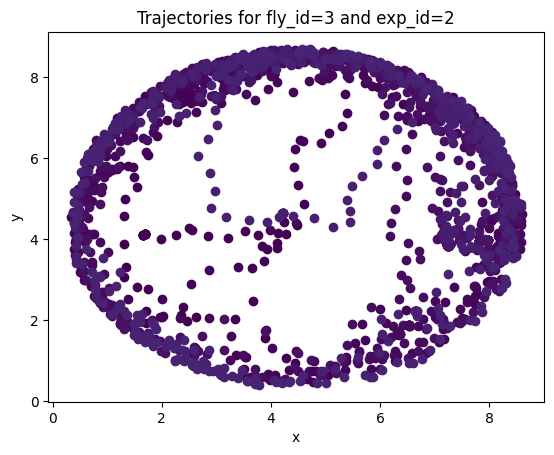

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis

# Define the desired 'fly_id' and 'exp_id'
desired_fly_id = 3
desired_exp_id = 2

colors = []

# Assign colors to the trajectory based on time
time_range = final_df['t'].max() - final_df['t'].min()
normalized_time = (final_df['t'] - final_df['t'].min()) / time_range
colors.extend(viridis(normalized_time))

# Filter the final dataframe based on desired 'fly_id' and 'exp_id'
filtered_df = final_df[(final_df['fly_id'] == desired_fly_id) & (final_df['exp_id'] == desired_exp_id)].reset_index(drop=True)
# print(filtered_df)

# Downsample the filtered dataframe to reduce the number of points
downsampled_df = filtered_df.iloc[::1]  # Change the downsample factor as per your requirement

# Plot line trajectories
fig, ax = plt.subplots()
for i in range(len(downsampled_df)):
    ax.scatter(downsampled_df['Cx'].iloc[i], downsampled_df['Cy'].iloc[i], color=colors[i])

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Trajectories for fly_id={desired_fly_id} and exp_id={desired_exp_id}')
# plt.colorbar(label='Time')
plt.show()

In [ ]:
final_df.vs_cm.hist(bins=31,
                    log=True,
                    alpha=0.7
                    )

AttributeError: ignored

In [ ]:
final_df.vr_deg.hist(bins=31,
                     log=True
                     )

In [ ]:
# https://wumbo.net/formulas/angle-between-two-vectors-2d/

SyntaxError: ignored

In [ ]:
'''
Each element in the list is a data frame with the following columns:

	[1] 't': time (collected at 100hz)
	[2] 'x': x position of the fly
	[3] 'y': y position of the fly
	[4] 'angle': angle of the fly in degrees
	[5] 'angle': angle of the fly in radians
	[6] 'theta': change in angle (in degrees)
	[7] 'vt': instantaneous translational velocity
	[8] 'vr': instantaneous angular velocity
	[9] 'vs': instantaneous sideslip
	[10] 'acc': acceleration of translational velocity
	[11] 'vt_cm': translational velocity calculated as cm/sec
	[12] 'vr_cm': angular velocity calculated as degrees/sec
	[13] 'vs_cm': sideslip calculate as cm/sec
	[14] 'acc_cm': acceleration calculated as cm/sec
	[15] 'vt_cm_smooth': smoothed translational velocity (cm/sec)
	[16] 'vr_cm_smooth': smoothed angular velocity (cm/sec)
	[17] 'vs_cm_smooth': smoothed sideslip (cm/sec)
	[18] 'exp': experiment id
	[19] 'fly': fly id
	[20] 'strain': strain/species
	[21] 'name': unique id

    '''